In [37]:
import numpy as np
import pandas as pd 
import seaborn as sns
import missingno as msno
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



import warnings 
warnings.filterwarnings("ignore")

In [38]:

# Define the file path
file_path = 'Student data.csv'

# Define the column names
columns = [
    "First Term Gpa", "Second Term Gpa", "First Language", "Funding", "School",
    "Fast Track", "Coop", "Residency", "Gender", "Prev Education", "Age Group",
    "High School Average Mark", "Math Score", "English Grade", "FirstYearPersistence"
]

columns = [col.lower().replace(' ', '_') for col in columns]

# Load the CSV file, skipping the first 25 rows
df = pd.read_csv(file_path, skiprows=25, header=None)

# Set the column names
df.columns = columns



Listing the categorical and numerical variable from the dataset description. 

In [39]:
categorical_variables = [
    "first_language",
    "funding",
    "school",
    "fast_track",
    "coop",
    "residency",
    "gender",
    "prev_education",
    "age_group",
    "english_grade",
]

numerical_variables = [
    "first_term_gpa",
    "second_term_gpa",
    "high_school_average_mark",
    "math_score"
]


#### Categorical variables analysis: 

In [40]:
# list all the categorial variables with "?" in them.
missing_cat = [] # categorical columns with missing values.
for cat in categorical_variables:  
    val_c = df[cat].value_counts()
    if "?" in val_c.index:
        missing_cat.append(cat)
    
print(f"Categorical Columns with '?' in them: {missing_cat}")

Categorical Columns with '?' in them: ['first_language', 'prev_education', 'age_group', 'english_grade']


Let's dive deeper into each of the variables. 

**first_language**

In [41]:
v_c = df["first_language"].value_counts().reset_index()
v_c

,first_language,count
0,1,719
1,3,602
2,?,111
3,2,4


Since first language has 3 possible values : 1 = English, 2 = French 2, 3 = Other This is not missing at random. 

**prev_education**

In [42]:
v_c = df["prev_education"].value_counts().reset_index()
v_c

,prev_education,count
0,1,862
1,2,482
2,0,88
3,?,4


**age_group**

In [43]:
v_c = df["age_group"].value_counts().reset_index()
v_c

,age_group,count
0,3,550
1,1,356
2,2,294
3,4,115
4,5,41
5,7,37
6,6,30
7,8,9
8,?,4


Here,  the missing age group represented by ? can be replaced by the only age group not listed on value count which is 9 (61 to 65).

In [44]:
df['age_group'] = df['age_group'].replace('?', 9)
df['age_group'] = pd.to_numeric(df['age_group'])


**english_grade**

In [45]:
v_c = df["english_grade"].value_counts().reset_index()
v_c

,english_grade,count
0,9,504
1,8,316
2,7,249
3,10,187
4,4,97
5,?,45
6,3,33
7,1,3
8,2,2


The missing value can be ambigious. It can be either 5 or 6.

Converting ? to `Nan` Value.

In [46]:
df.replace('?',np.NaN, inplace=True)

**Missingness Analysis**

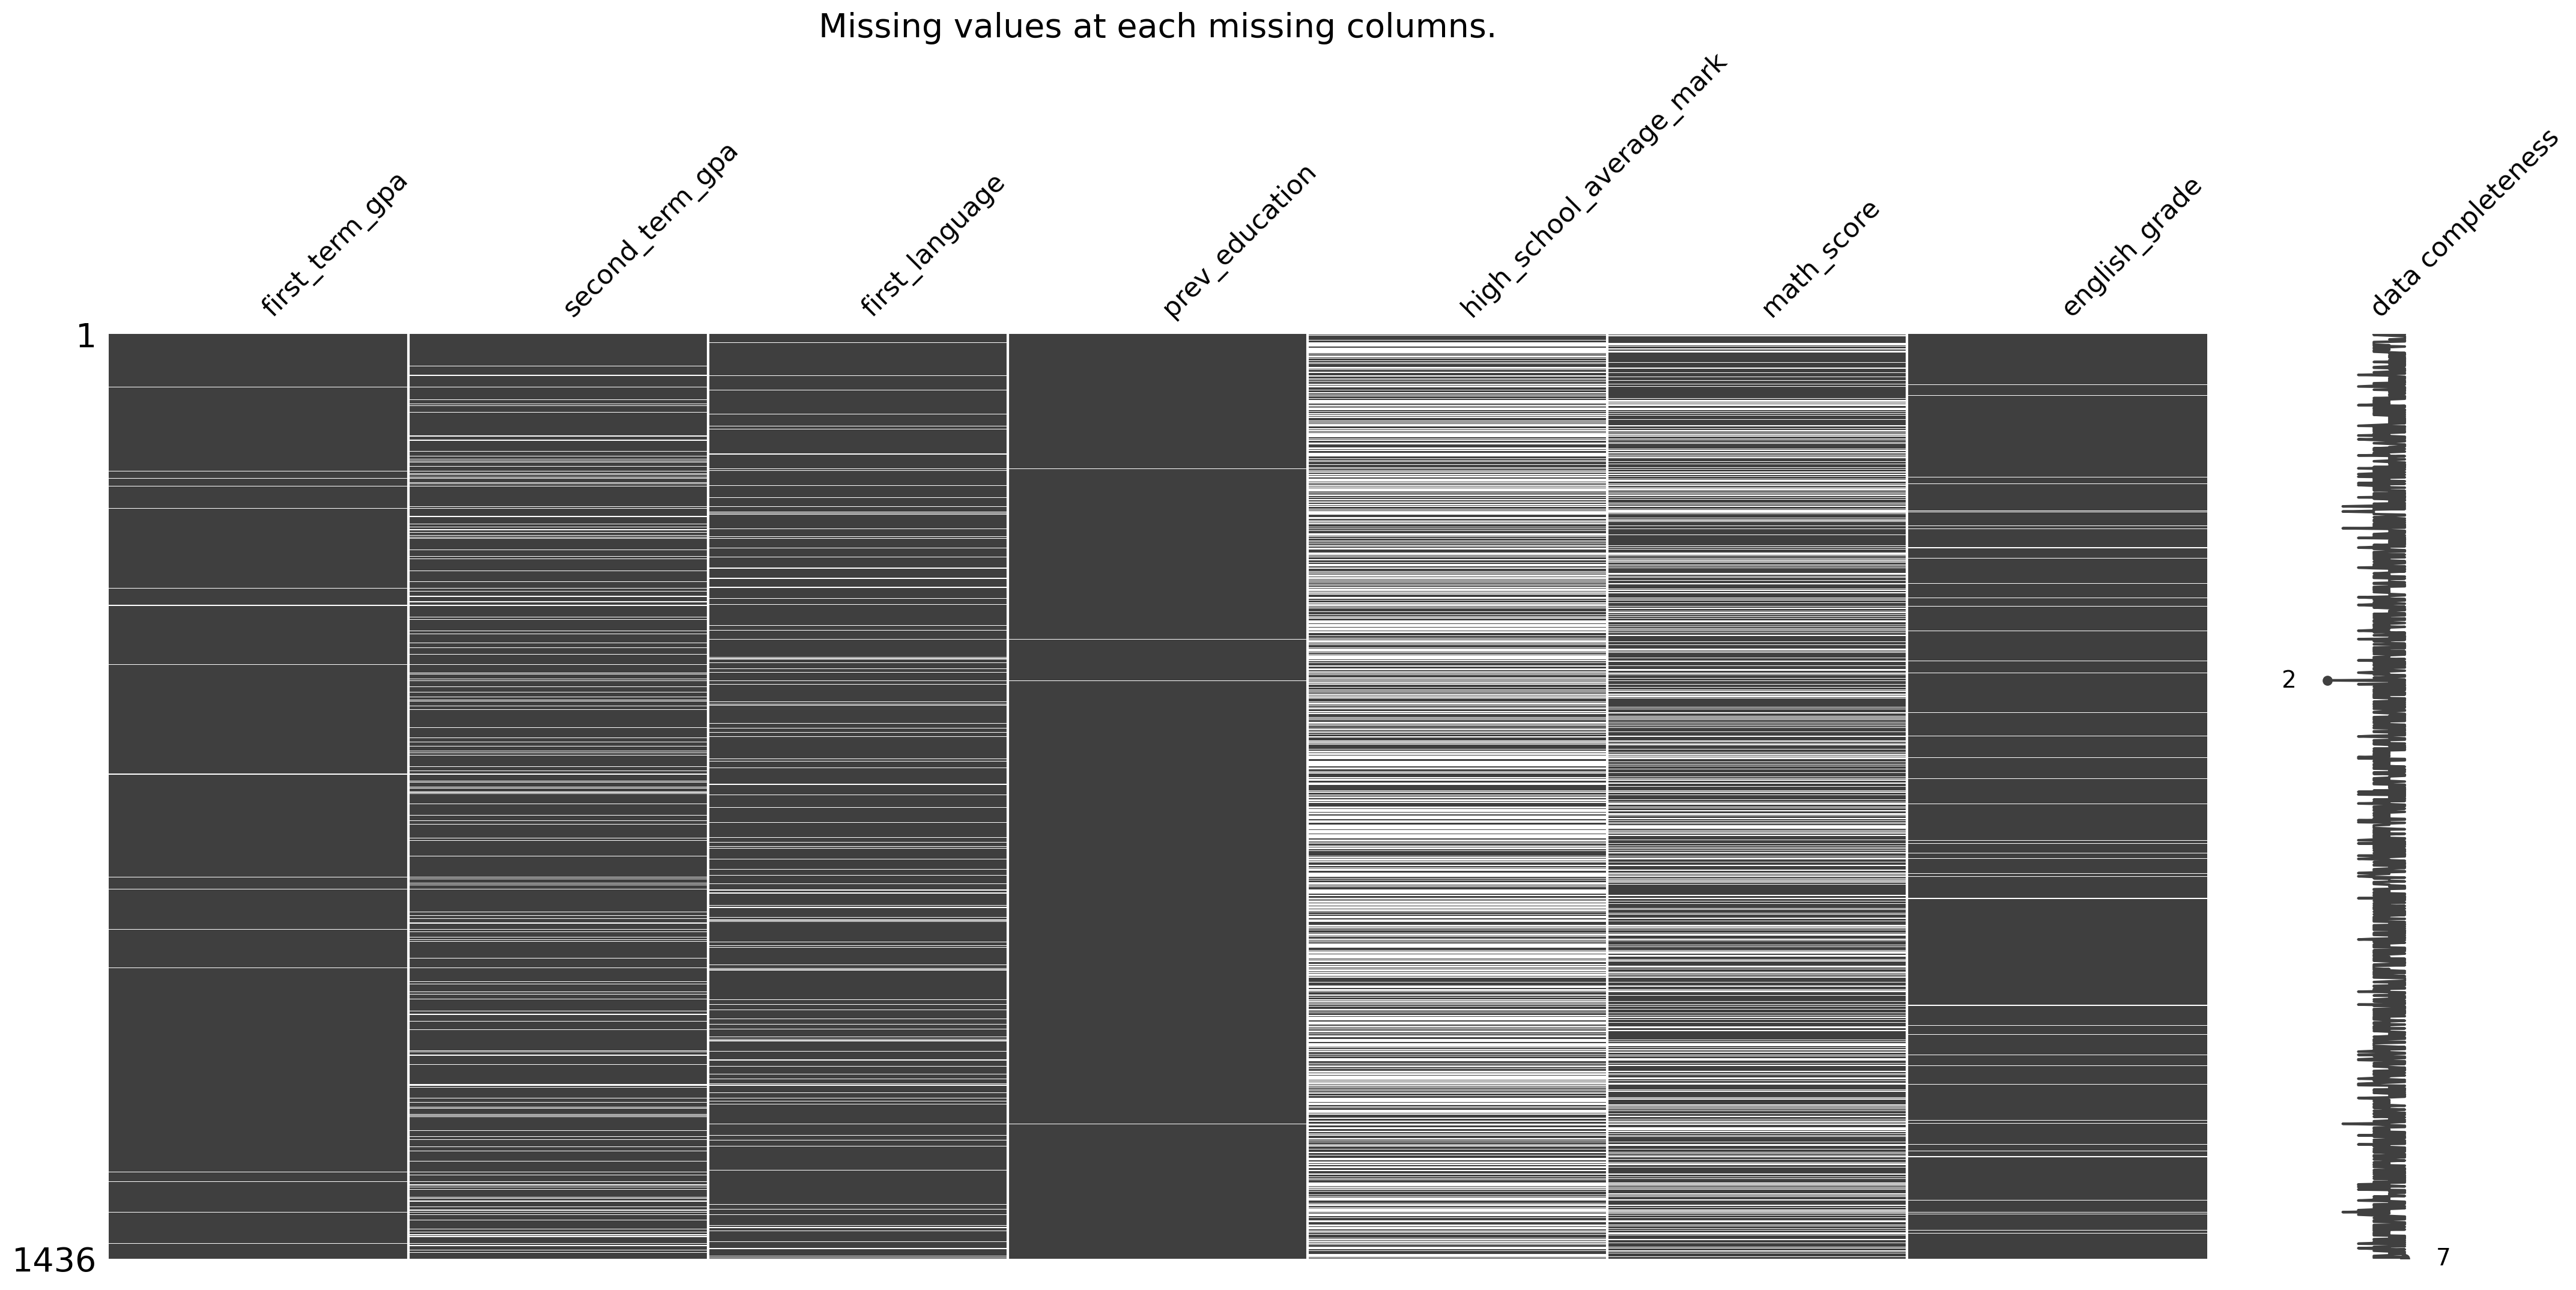

In [47]:
col_mis_val = df.columns[df.isnull().sum() > 0]
col_mis_val = col_mis_val.to_list()
msno.matrix(df[col_mis_val],labels="Missing Values ")
plt.title("Missing values at each missing columns.",fontsize=20)
plt.show()

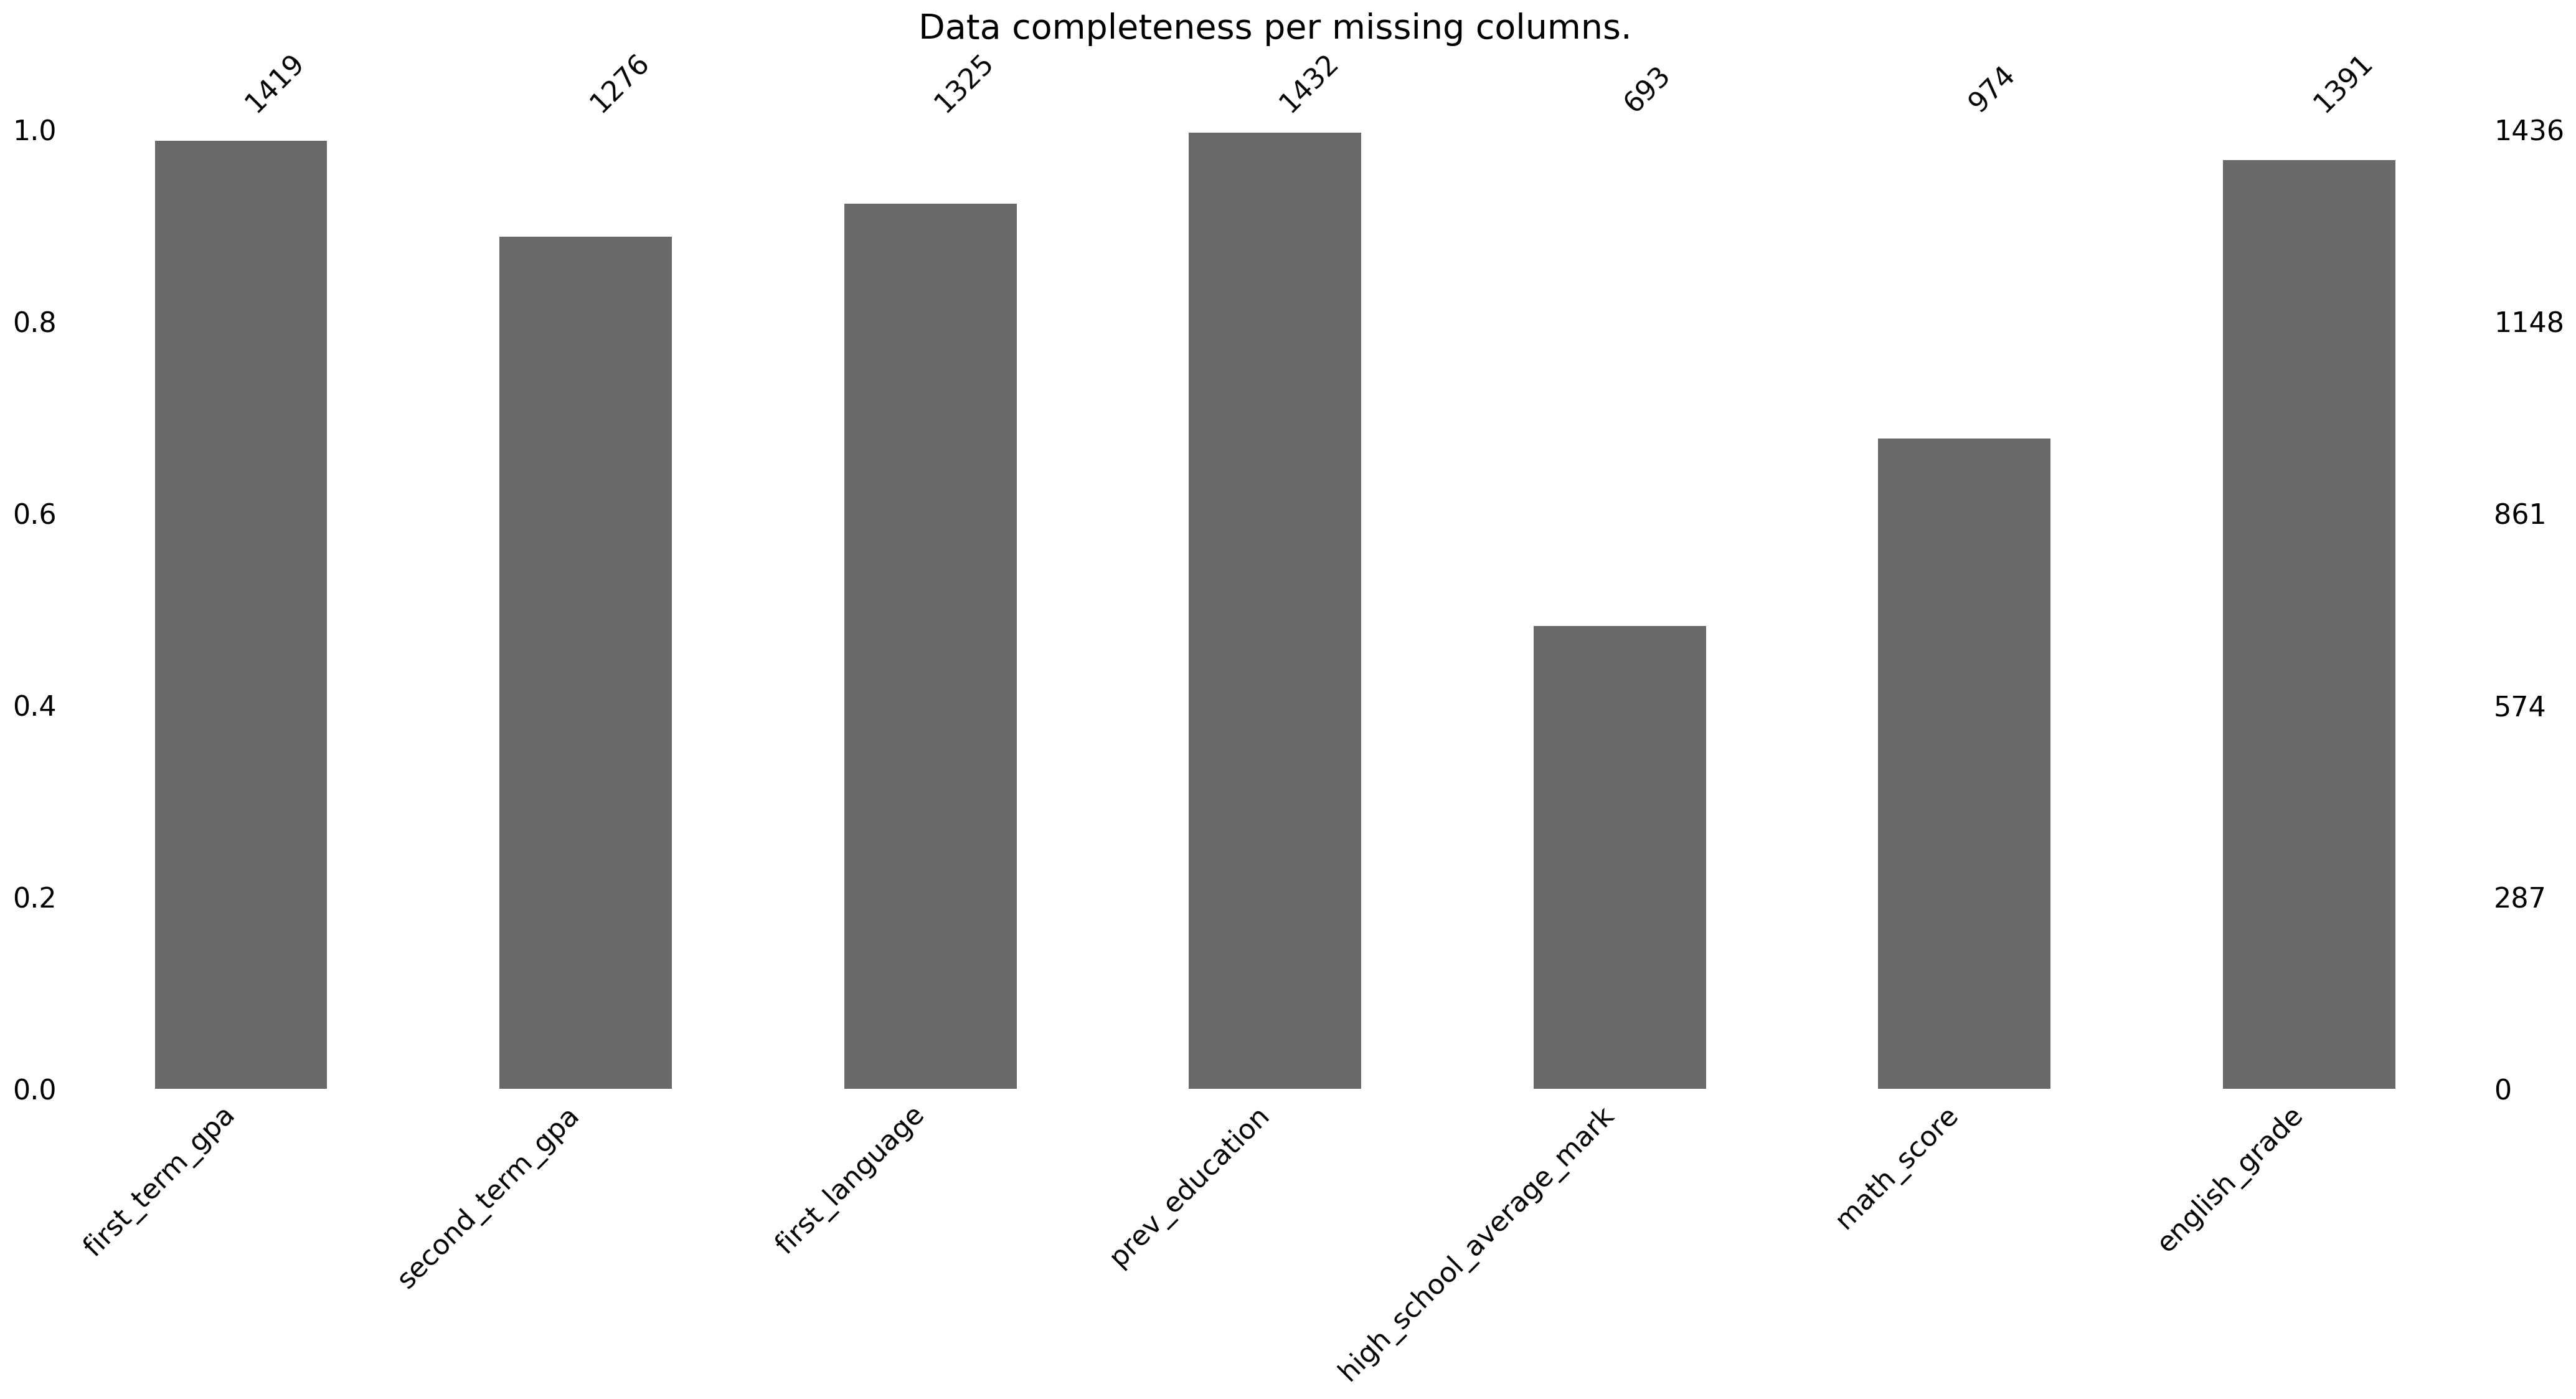

In [48]:
msno.bar(df[col_mis_val],labels="Missing Values ")
plt.title("Data completeness per missing columns.",fontsize=20)
plt.show()

#### Handelling the missing values

In [49]:
# covert all numerical to numerical 
for k in numerical_variables:
    df[str(k)] = pd.to_numeric(df[str(k)])


In [50]:
classifier_cols = categorical_variables
bool_cols = []
regressor_cols = numerical_variables

fe_df = df[classifier_cols+regressor_cols]
fe_df.head()

missing_data_cols = fe_df.isnull().sum()[fe_df.isnull().sum() > 0].index.tolist()



def impute_categorical_missing_data(passed_col):
    
    df_null = fe_df[fe_df[passed_col].isnull()]
    df_not_null = fe_df[fe_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = fe_df[fe_df[passed_col].isnull()]
    df_not_null = fe_df[fe_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [51]:
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((fe_df[col].isnull().sum() / len(fe_df)) * 100, 2))+"%")
    if col in classifier_cols:
        fe_df[col] = impute_categorical_missing_data(col)
    elif col in regressor_cols:
        fe_df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values first_language : 7.73%
The feature 'first_language' has been imputed with 91.32 accuracy

Missing Values prev_education : 0.28%
The feature 'prev_education' has been imputed with 71.43 accuracy

Missing Values english_grade : 3.13%
The feature 'english_grade' has been imputed with 49.46 accuracy

Missing Values first_term_gpa : 1.18%
MAE = 0.4948363092928403 

Missing Values second_term_gpa : 11.14%
MAE = 0.5176135636753165 

Missing Values high_school_average_mark : 51.74%
MAE = 7.574964028776979 

Missing Values math_score : 32.17%
MAE = 5.8114871794871785 



Lets look at the missiness now:

In [65]:
fe_df.to_csv("static/cleaned.csv")

**Feature Engineering**

In [55]:

# lets divide our categorical columns into nominal and ordinal 
nominal_variables = [
    "first_language",
    "funding",
    "school",
    "fast_track",
    "coop",
    "residency",
    "gender",
    "prev_education"
]

ordinal_variables = [
    "age_group",
    "english_grade"
]

numerical_variables = [
    "first_term_gpa",
    "second_term_gpa",
    "high_school_average_mark",
    "math_score"
]


# ##################### One-hot encoding to Nominal ##############################################
nominal_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# ########################## Ordinal Encoding for ordinal variables ###############################
ordinal_pipe = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# ########################## Ordinal Encoding for ordinal variables ###############################
numerical_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

################################## Combined Pipe ####################################################
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_pipe, nominal_variables),
        ('ordinal', ordinal_pipe, ordinal_variables),
        ('numerical', numerical_pipe, numerical_variables)
    ]
)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


# perform the transformation 
processed_data = full_pipeline.fit_transform(fe_df)

processed_data_df = pd.DataFrame(processed_data, columns=full_pipeline.named_steps['preprocessor'].get_feature_names_out())

# add the traget column to the processed dataset. 
processed_data_df['firstyearpersistence'] = df['firstyearpersistence'].values



In [57]:
class StudentsDataset(Dataset):
    """Converts given train test splited tabular data into pytorch dataset.
    """
    def __init__(self, X, y):
        self.X = X
        
        # reshape y in (batchsize, target)
        self.y = y.view(-1, 1)  
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# split data into dependent and independer 
X = processed_data_df.drop('firstyearpersistence', axis=1).values
y = processed_data_df['firstyearpersistence'].values

# perform the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# converting int to float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Initialize the student dataset.
train_dataset = StudentsDataset(X_train_tensor, y_train_tensor)
test_dataset = StudentsDataset(X_test_tensor, y_test_tensor)



Model, Hyperparameters, loss and optimizers:

In [58]:
class Hyperparameters(object):
      def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=32,
                     batch_size=16,
                     lr=0.00005,                     
                     n_cpu=8)

# define the simple neural net.
class StudentNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(StudentNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x



# load the train and test loder
train_loader = DataLoader(train_dataset, batch_size=hp.batch_size, shuffle=True, num_workers=hp.n_cpu)
test_loader = DataLoader(test_dataset, batch_size=hp.batch_size, shuffle=False, num_workers=hp.n_cpu)

# initialize the model, loss and learning rate
model = StudentNeuralNet(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



As we dont have enought training data, to prevent model from overfitting, let's write a custom callback.

In [59]:
# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, min_delta=0.001, patience=20, restore_best_weights=True):
        self.min_delta = min_delta
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def __call__(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


# set patience = 5, if there is no significant changes in 5 epochs, stop the training.
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [60]:
# Initialize dictionaries to store losses and accuracies
metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}



for epoch in range(hp.n_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training loop with tqdm
    for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{hp.n_epochs} [Training]"):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    metrics['train_loss'].append(train_loss)
    metrics['train_accuracy'].append(train_accuracy)
    
    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    correct_test = 0
    total_test = 0
    
    # Testing loop with tqdm
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{hp.n_epochs} [Testing]"):
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()
    
    val_loss /= len(test_loader)
    test_accuracy = correct_test / total_test
    metrics['test_loss'].append(val_loss)
    metrics['test_accuracy'].append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{hp.n_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {val_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    # Check early stopping
    if early_stopping(val_loss):
        print("Early stopping triggered")
        break


Epoch 1/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 73.21it/s]


Epoch [1/32], Train Loss: 0.5422, Train Accuracy: 0.7735, Test Loss: 0.4540, Test Accuracy: 0.8194


Epoch 2/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 85.77it/s]


Epoch [2/32], Train Loss: 0.4877, Train Accuracy: 0.7848, Test Loss: 0.4255, Test Accuracy: 0.8194


Epoch 3/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 79.22it/s]


Epoch [3/32], Train Loss: 0.4617, Train Accuracy: 0.7848, Test Loss: 0.3852, Test Accuracy: 0.8194


Epoch 4/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 82.07it/s]


Epoch [4/32], Train Loss: 0.4356, Train Accuracy: 0.7901, Test Loss: 0.3593, Test Accuracy: 0.8681


Epoch 5/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 83.11it/s]


Epoch [5/32], Train Loss: 0.4050, Train Accuracy: 0.8284, Test Loss: 0.3327, Test Accuracy: 0.8715


Epoch 6/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 73.16it/s]


Epoch [6/32], Train Loss: 0.3899, Train Accuracy: 0.8354, Test Loss: 0.3280, Test Accuracy: 0.8750


Epoch 7/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 77.50it/s]


Epoch [7/32], Train Loss: 0.3699, Train Accuracy: 0.8606, Test Loss: 0.3269, Test Accuracy: 0.8681


Epoch 8/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 79.12it/s]


Epoch [8/32], Train Loss: 0.3592, Train Accuracy: 0.8571, Test Loss: 0.3275, Test Accuracy: 0.8785


Epoch 9/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 78.78it/s]


Epoch [9/32], Train Loss: 0.3586, Train Accuracy: 0.8580, Test Loss: 0.3267, Test Accuracy: 0.8750


Epoch 10/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 64.80it/s]


Epoch [10/32], Train Loss: 0.3545, Train Accuracy: 0.8563, Test Loss: 0.3199, Test Accuracy: 0.8958


Epoch 11/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 81.78it/s]


Epoch [11/32], Train Loss: 0.3470, Train Accuracy: 0.8598, Test Loss: 0.3141, Test Accuracy: 0.8819


Epoch 12/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 77.12it/s]


Epoch [12/32], Train Loss: 0.3423, Train Accuracy: 0.8676, Test Loss: 0.3146, Test Accuracy: 0.8854


Epoch 13/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 80.98it/s]


Epoch [13/32], Train Loss: 0.3425, Train Accuracy: 0.8632, Test Loss: 0.3227, Test Accuracy: 0.8924


Epoch 14/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 74.88it/s]


Epoch [14/32], Train Loss: 0.3414, Train Accuracy: 0.8606, Test Loss: 0.3289, Test Accuracy: 0.8785


Epoch 15/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 84.28it/s]


Epoch [15/32], Train Loss: 0.3401, Train Accuracy: 0.8615, Test Loss: 0.3276, Test Accuracy: 0.8785


Epoch 16/32 [Testing]: 100%|██████████| 18/18 [00:00<00:00, 72.14it/s]

Epoch [16/32], Train Loss: 0.3397, Train Accuracy: 0.8659, Test Loss: 0.3237, Test Accuracy: 0.8889
Early stopping triggered


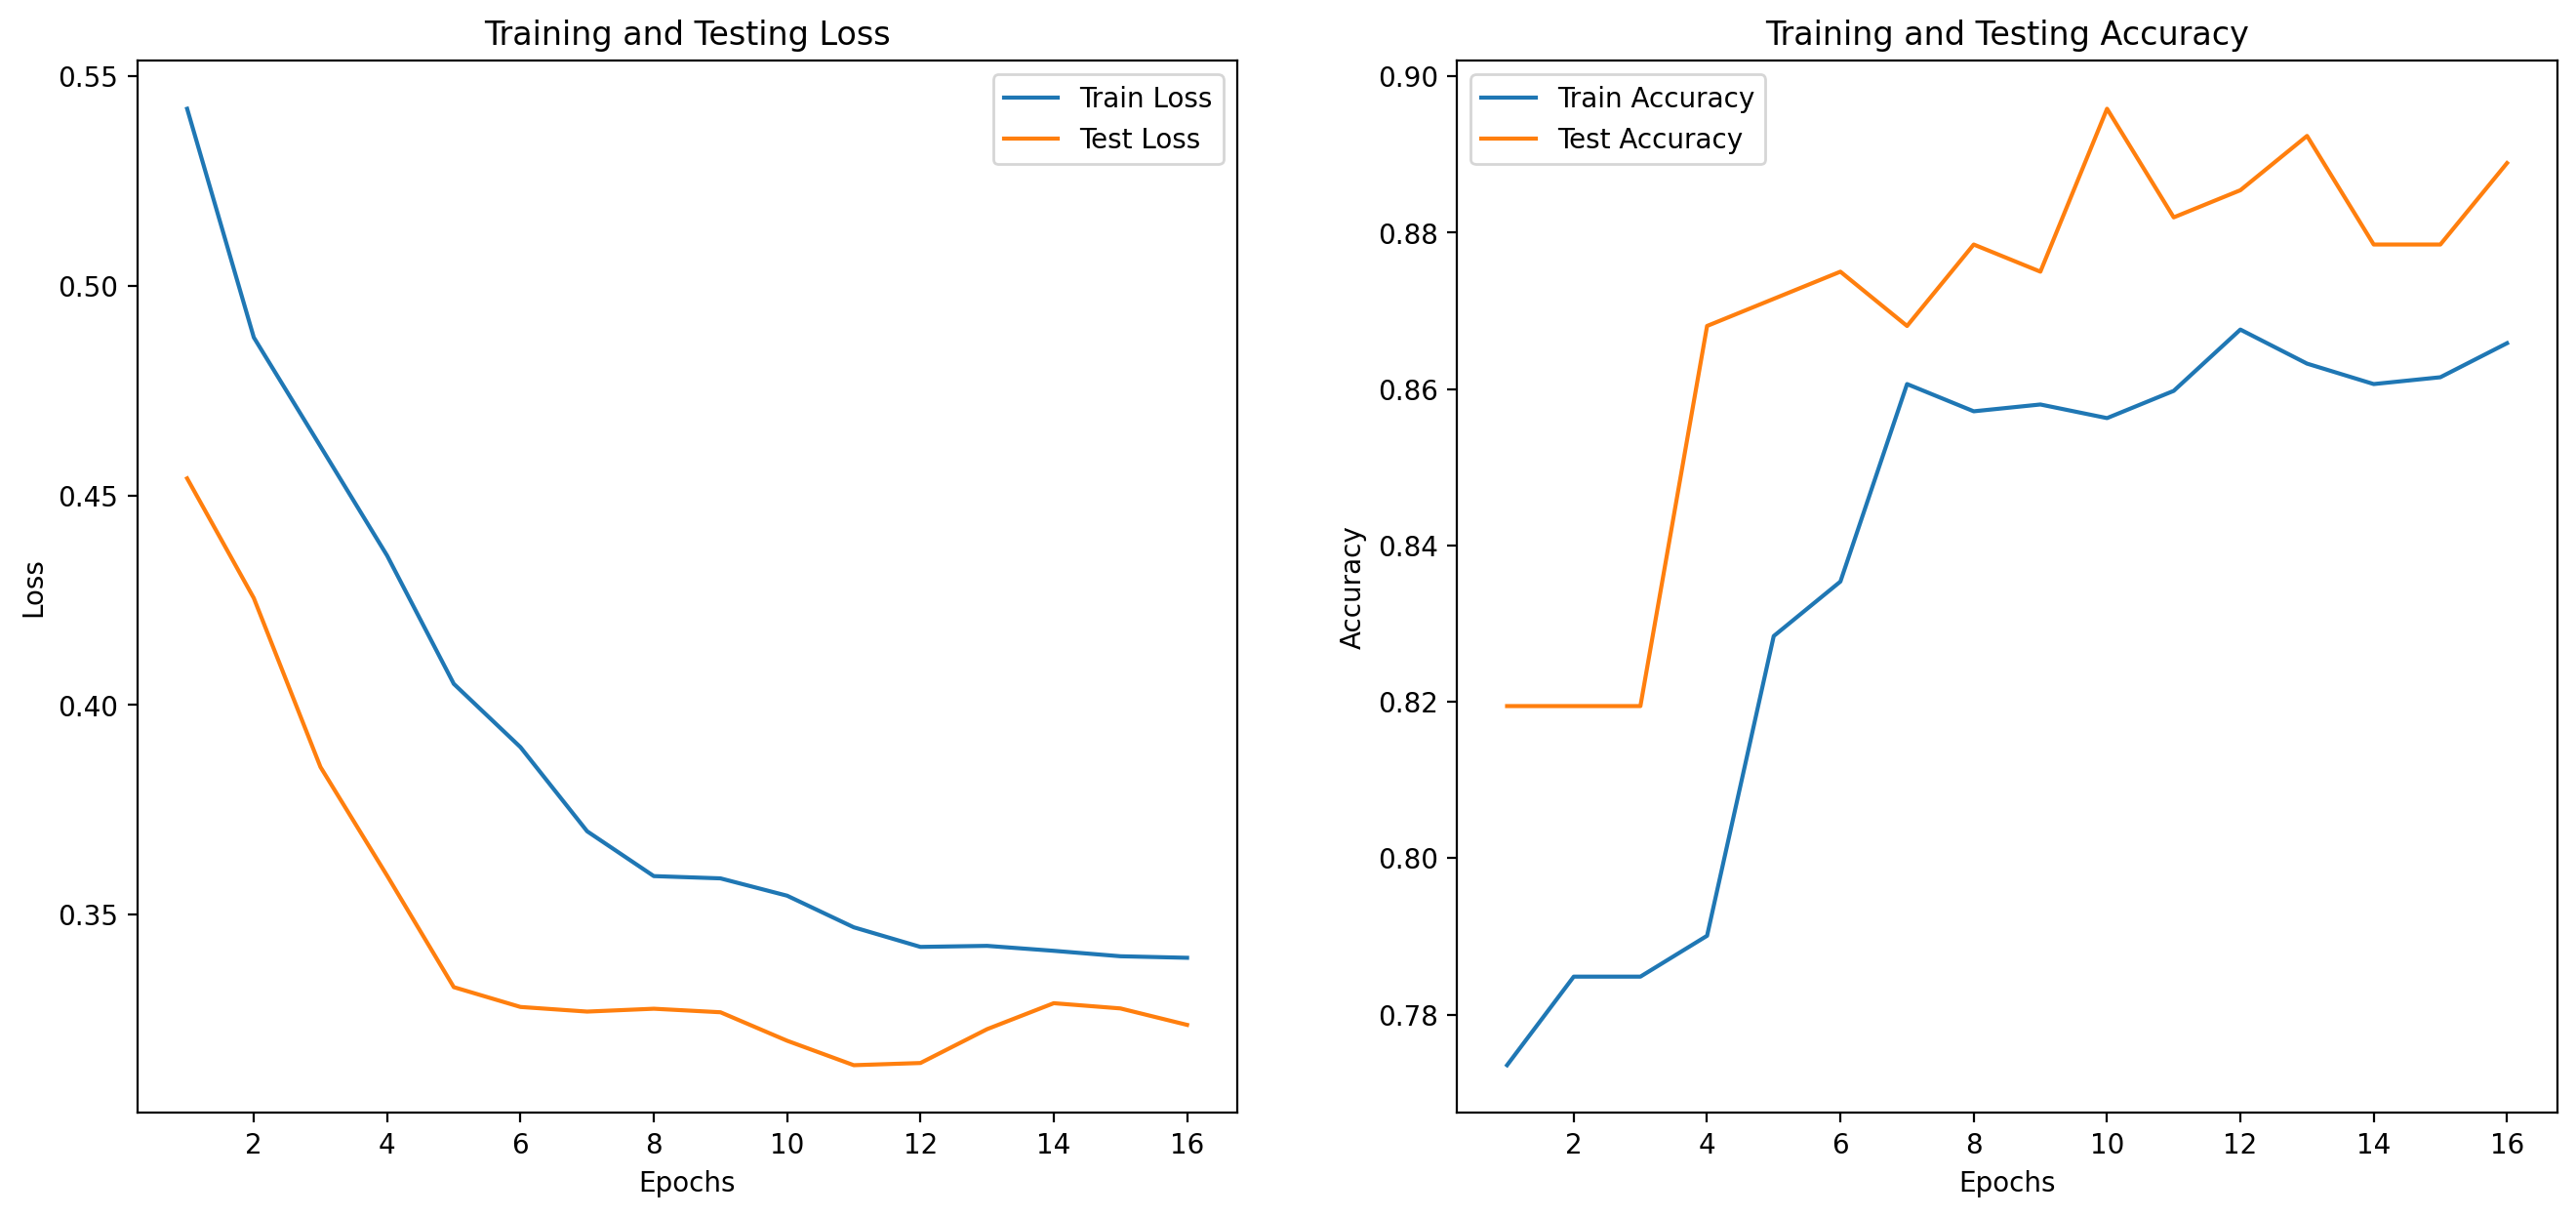

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, (16-1)//2))

ax1.plot(range(1, len(metrics['train_loss']) + 1), metrics['train_loss'], label='Train Loss')
ax1.plot(range(1, len(metrics['test_loss']) + 1), metrics['test_loss'], label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Testing Loss')
ax1.legend()

ax2.plot(range(1, len(metrics['train_accuracy']) + 1), metrics['train_accuracy'], label='Train Accuracy')
ax2.plot(range(1, len(metrics['test_accuracy']) + 1), metrics['test_accuracy'], label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Testing Accuracy')
ax2.legend()

plt.show()

**Classification Reports:**

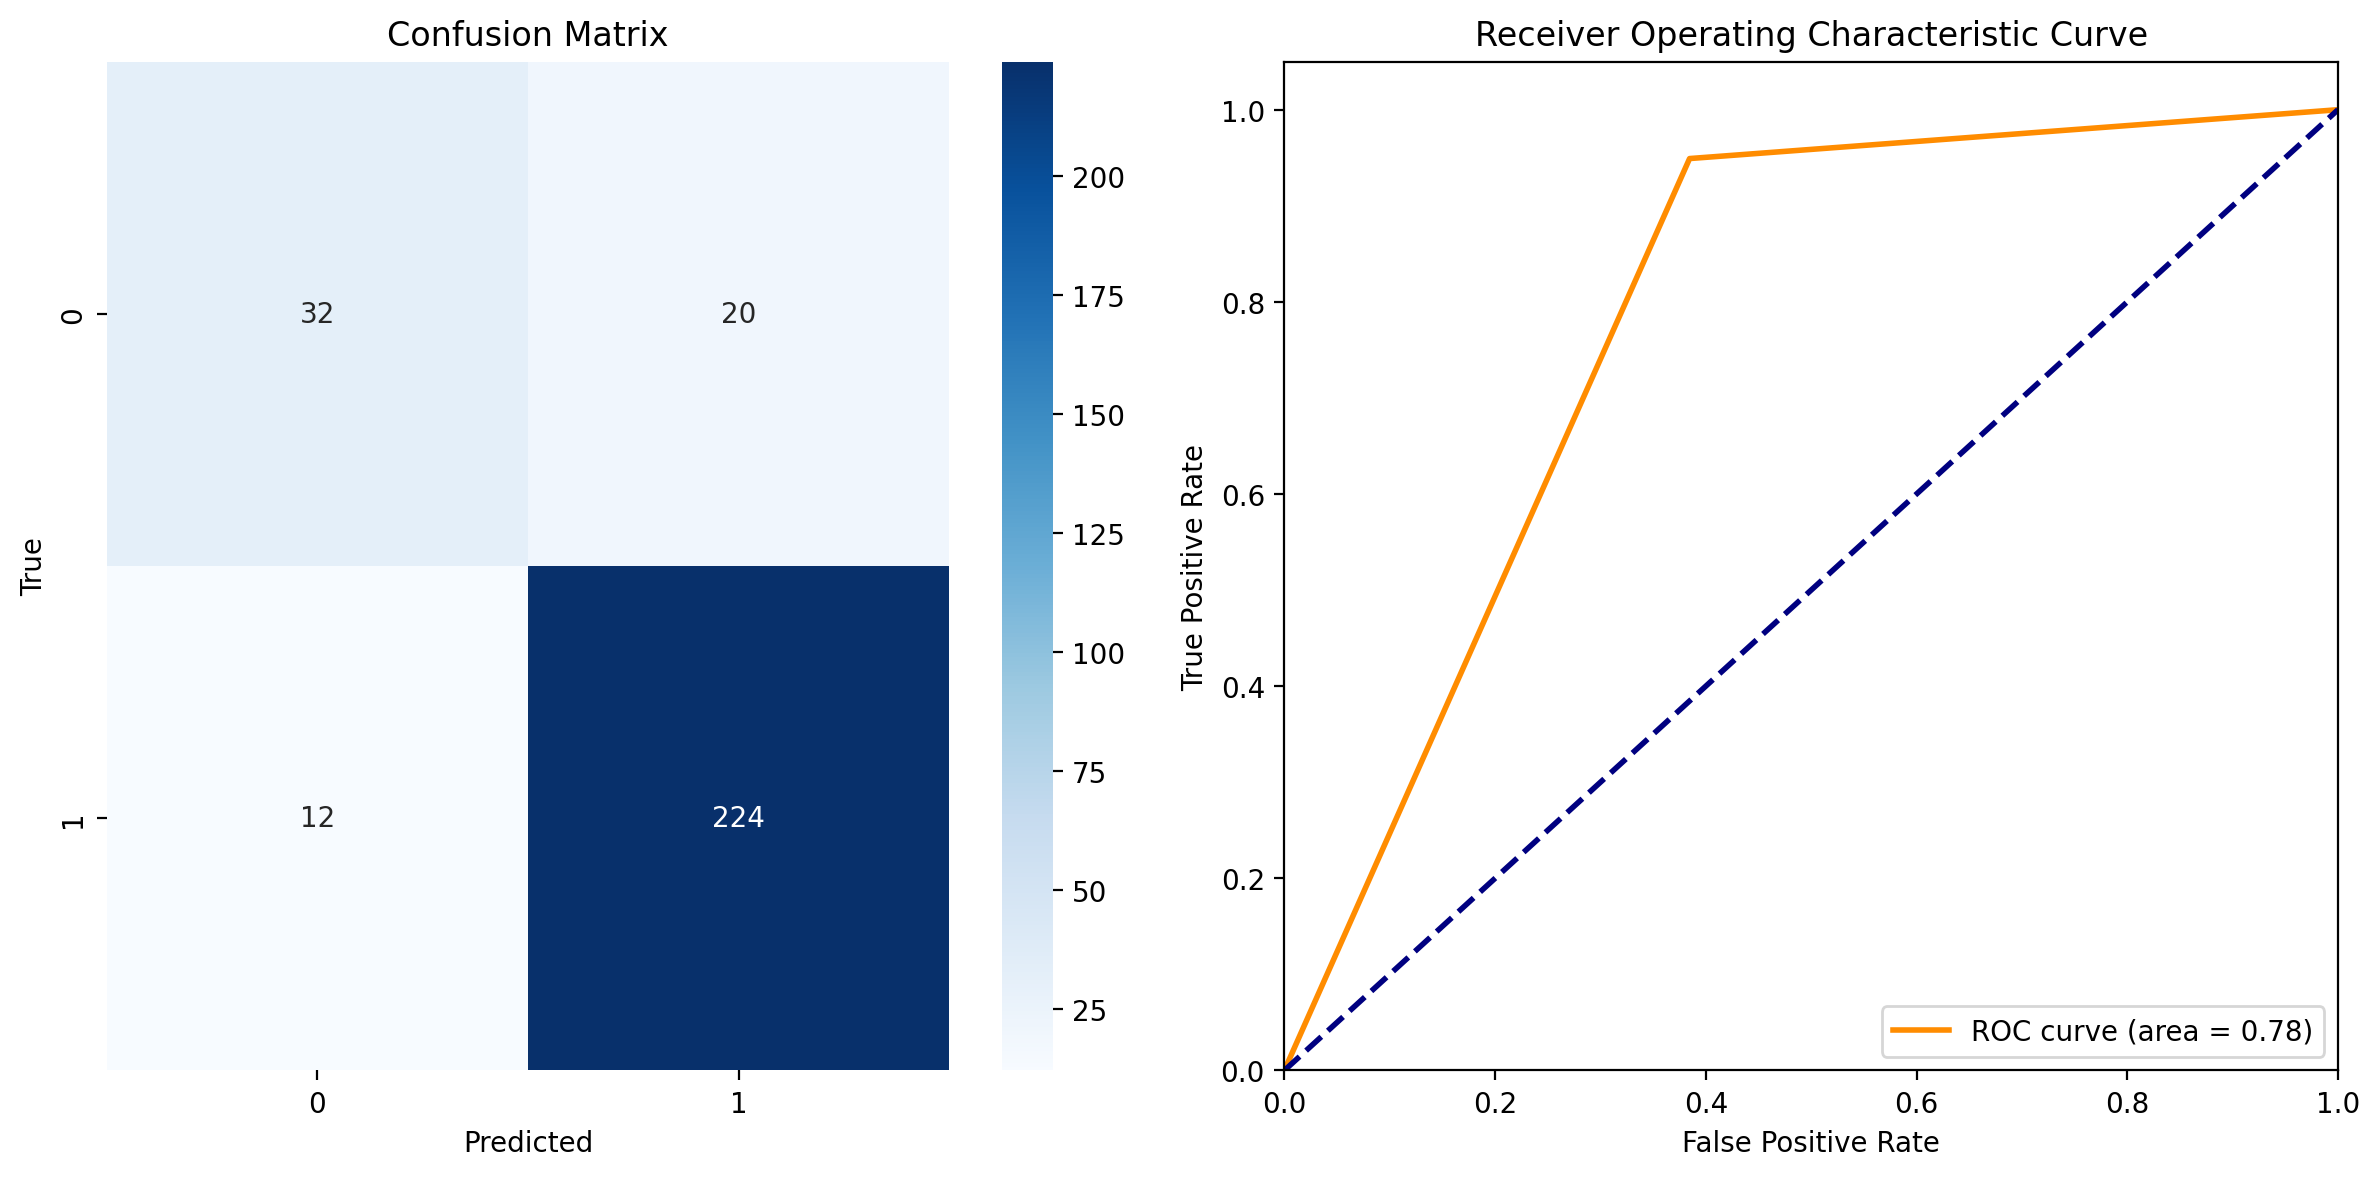

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.62      0.67        52
     Class 1       0.92      0.95      0.93       236

    accuracy                           0.89       288
   macro avg       0.82      0.78      0.80       288
weighted avg       0.88      0.89      0.89       288



In [62]:
# set the model to evaluation mode 
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        
        # if output > 0.5, convert to class 1 
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(batch_y.numpy())



############# Confustion Matrix ###########

cm = confusion_matrix(y_true, y_pred)

############# Calculate ROC and AUC #################
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix')


ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
ax2.legend(loc='lower right')

plt.tight_layout()

plt.show()



# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)


In [63]:
torch.save(model.state_dict(), 'model.pth')